In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pypoman
import scipy.spatial
import polytope
import torch

import pynever.strategies.abstraction as abst
import pynever.nodes as nodes
import pynever.strategies.verification as ver
import pynever.networks as networks
import pynever.utilities as utils
import pynever.strategies.conversion as conv


def plot_star(p_star: abst.Star, show=False, title=None, color = np.array([0.5, 0.5, 1])):

    #color = np.random.rand(3)
    alpha_vertexes = pypoman.compute_polytope_vertices(p_star.predicate_matrix, p_star.predicate_bias)
    x_vertexes = []
    for v in alpha_vertexes:
        v_ver = np.zeros((v.shape[0], 1))
        for k in range(v.shape[0]):
            v_ver[k, 0] = v[k]
        new_x_v = p_star.center + np.matmul(p_star.basis_matrix, v_ver)
        x_vertexes.append(new_x_v)

    x1_plot = []
    x2_plot = []
    for v in x_vertexes:
        x1_plot.append(v[0, 0])
        x2_plot.append(v[1, 0])

    for k in range(len(x1_plot)):
        for j in range(len(x1_plot)):
            plt.plot([x1_plot[k], x1_plot[j]], [x2_plot[k], x2_plot[j]], color=color)

    plt.scatter(x1_plot, x2_plot, color=color)
    if show:
        if title is not None:
            plt.title(title)
        plt.grid()


def plot_starset(p_starset: abst.StarSet, title, color = np.array([0.5, 0.5, 1])):
    for p_star in p_starset.stars:

        plot_star(p_star, color=color)

    if title is not None:
        plt.title(title)
    plt.grid()


def get_star_extreme_points(p_star: abst.Star):

    x_vertexes = []
    alpha_vertexes = pypoman.compute_polytope_vertices(p_star.predicate_matrix, p_star.predicate_bias)
    for v in alpha_vertexes:
        v_ver = np.zeros((v.shape[0], 1))
        for k in range(v.shape[0]):
            v_ver[k, 0] = v[k]
        new_x_v = p_star.center + np.matmul(p_star.basis_matrix, v_ver)
        new_x_v = np.array([new_x_v[0, 0], new_x_v[1, 0]])
        x_vertexes.append(new_x_v)

    x_vertexes = np.array(x_vertexes)

    return x_vertexes

def get_starset_extreme_points(p_starset: abst.StarSet):
    x_vertexes = []
    for p_star in p_starset.stars:
        alpha_vertexes = pypoman.compute_polytope_vertices(p_star.predicate_matrix, p_star.predicate_bias)
        for v in alpha_vertexes:
            v_ver = np.zeros((v.shape[0], 1))
            for k in range(v.shape[0]):
                v_ver[k, 0] = v[k]
            new_x_v = p_star.center + np.matmul(p_star.basis_matrix, v_ver)
            new_x_v = np.array([new_x_v[0, 0], new_x_v[1, 0]])
            x_vertexes.append(new_x_v)

    x_vertexes = np.array(x_vertexes)
    return x_vertexes


def plot_convex_hull(points: np.ndarray, title = None, color=None, alpha=1, label=None):

    hull = scipy.spatial.ConvexHull(points)
    vertexes = points[hull.vertices, :]
    vertexes = np.vstack((vertexes, vertexes[0, :]))
    if color is None:
        plt.fill(vertexes[:, 0], vertexes[:, 1], alpha=0.5, label=label)
    else:
        plt.fill(vertexes[:, 0], vertexes[:, 1], color=color, alpha=alpha, label=label)
    
    if title is not None:
        plt.title(title)
    plt.grid()


def print_star_data(p_star: abst.Star):

    print("PREDICATE CONSTRAINTS:")
    for row in range(p_star.predicate_matrix.shape[0]):
        constraint = ""
        for col in range(p_star.predicate_matrix.shape[1]):
            if p_star.predicate_matrix[row, col] < 0:
                sign = "-"
            else:
                sign = "+"
            constraint = constraint + f"{sign} {abs(p_star.predicate_matrix[row, col])} * x_{col} "

        constraint = constraint + f"<= {p_star.predicate_bias[row, 0]}"
        print(constraint)

    print("VARIABLES EQUATIONS:")
    for row in range(p_star.basis_matrix.shape[0]):
        equation = f"z_{row} = "
        for col in range(p_star.basis_matrix.shape[1]):
            if p_star.basis_matrix[row, col] < 0:
                sign = "-"
            else:
                sign = "+"
            equation = equation + f"{sign} {abs(p_star.basis_matrix[row, col])} * x_{col} "

        if p_star.center[row, 0] < 0:
            c_sign = "-"
        else:
            c_sign = "+"
        equation = equation + f"{c_sign} {abs(p_star.center[row, 0])}"
        print(equation)

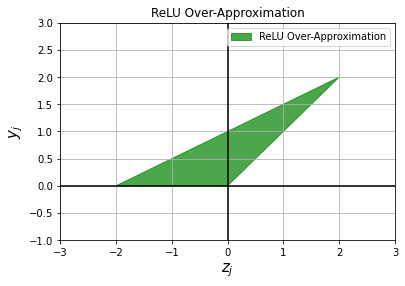

In [2]:
overapprox = polytope.qhull(np.array([[0, 0], [-2, 0], [2, 2]]))

plot_convex_hull(overapprox.vertices, color='green', alpha=0.7, label="ReLU Over-Approximation", title="ReLU Over-Approximation")
plt.xlim([-3,3])
plt.ylim([-1,3])
plt.xlabel("$z_j$", size=15)
plt.ylabel("$y_j$", size=15)
plt.axhline(0, color='black')
plt.axvline(0, color='black')
plt.legend()
plt.savefig(f"ReLU Overapprox.pdf")
plt.show()

We need 3 constraints for the over-approximation:

1) $y_j \geq 0$  
2) $y_j \geq z_j$  
3) $y_j \leq ub_j \cdot \frac{z_j - lb_j}{ub_j - lb_j}$  

The constraints must be added to the predicate matrix of the star, therefore we define an auxiliarly variable $x_{m+1}$ and we modify the basis matrix so that $y_j = x_{m+1}$.
We remember that $z_j = V_j \mathbf{x} + c_j$, substituting it in the constraints we obtain:

1) $x_{m+1} \geq 0$  
2) $x_{m+1} \geq V_j \mathbf{x} + c_j$  
3) $x_{m+1} \leq ub_j \cdot \frac{V_j \mathbf{x} + c_j - lb_j}{ub_j - lb_j}$  

We shuffle a bit the constraints to bring them in the format $C\mathbf{x} \leq \mathbf{d}$:

1) $- x_{m+1} \leq 0$  
2) $V_j \mathbf{x} - x_{m+1} \leq -c_j$  
3) $- \frac{ub_j}{ub_j-lb_j} V_j \mathbf{x} + x_{m+1} \leq \frac{ub_j}{ub_j-lb_j}(c_j - l_j)$  

The resulting matrixes C_1, C_2 and C_3 and biases d_1, d_2, d_3 are:

1) $C_1 = [0\ 0\ 0\ ...\ -1] \in \mathbb{R}^{1 \times m+1},\quad d_1 = 0$  
2) $C_2 = [V_j\quad -1] \in \mathbb{R}^{1 \times m+1},\quad d_2 = -c_j$  
3) $C_3 = [- \frac{ub_j}{ub_j-lb_j} V_j\quad 1] \in \mathbb{R}^{1 \times m+1},\quad d_3 = \frac{ub_j}{ub_j-lb_j}(c_j - l_j)$  